

**CogDL Notebook**
created by CogDL Team
[cogdlteam@gmail.com]

This notebook shows how to build applications based on CogDL pipeline. 

CogDL Link: https://github.com/THUDM/CogDL

Colab Link: https://colab.research.google.com/drive/1V47IIanXxDxi0Qsd6feOvvyYuqXcFP6P?usp=sharing


**使用cogdl的pipeline API来搭建应用**

---



1. 通过pip install来安装最新的cogdl。同时安装用于可视化的seaborn库。

Notes: 如果安装失败，请手动从https://github.com/THUDM/cogdl 下载源码进行安装。（记得点个star支持一下我们）


In [ ]:
!pip install git+https://github.com/THUDM/cogdl
!pip install seaborn

  Cloning https://github.com/THUDM/cogdl to /tmp/pip-req-build-bd6quyfj
  Running command git clone -q https://github.com/THUDM/cogdl /tmp/pip-req-build-bd6quyfj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 184 kB 5.0 MB/s 
     |████████████████████████████████| 191 kB 9.1 MB/s 
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 10.7 MB/s 
     |████████████████████████████████| 282 kB 21.7 MB/s 
     |████████████████████████████████| 2.6 MB 25.7 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 164 kB 54.6 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 141 kB 63.9 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |██████████████████████

2. 从cogdl中加载Yelp2018数据集（训练数据保存在train_cf下）

In [ ]:
from cogdl.datasets import build_dataset_from_name

dataset = build_dataset_from_name("yelp2018")
data = dataset[0]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Failed to load C version of sampling, use python version instead.
unpacking yelp2018.zip
Processing...
reading train and test user-item set ...
building the adj mat ...
loading done.
Done!


3. 从原图中抽样一个小图：取前100000条交互数据，同时只保留编号小于3000的商品

In [ ]:
import numpy as np

train_data = data.train_cf[:100000].copy()
train_data = train_data[train_data[:, 1] < 3000]
print(train_data)

# 对user/item重新进行编号
users = list(set(train_data[:, 0]))
users.sort()
num_users = len(users)
user_map = dict(zip(users, list(range(num_users))))

items = list(set(train_data[:, 1]))
items.sort()
num_items = len(items)
item_map = dict(zip(items, list(range(num_items))))

for i in range(len(train_data)):
    train_data[i, 0] = user_map[train_data[i, 0]]
    train_data[i, 1] = item_map[train_data[i, 1]]

print("重标号后的用户/商品数目：", num_users, num_items)

train_data[:, 1] += num_users
train_data = np.concatenate((train_data, np.array([(y, x) for (x, y) in train_data])), axis=0)
print(train_data)

[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [1990 1683]
 [1990 2724]
 [1990  807]]
重标号后的用户/商品数目： 1949 3000
[[   0 1949]
 [   0 1950]
 [   0 1951]
 ...
 [3632 1948]
 [4673 1948]
 [2756 1948]]


4. 通过cogdl的pipeline API来获取训练集中用户和商品的表示

In [ ]:
from cogdl import pipeline

# 使用cogdl的pipelie API来生成用户和商品的表示(可以选用prone模型)
generator = pipeline("generate-emb", model="prone")
embs = generator(train_data)

user_embs = embs[:num_users]
item_embs = embs[num_users:]
print(user_embs.shape, item_embs.shape)

(1949, 128) (3000, 128)


5. 将得到的用户/商品表示进行可视化

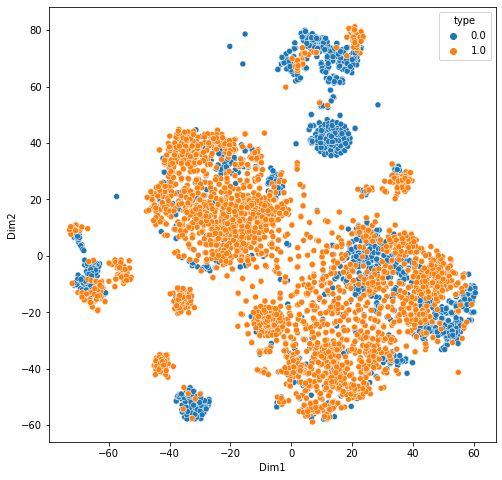

In [ ]:
from sklearn.manifold import TSNE 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# 使用TSNE将embs降到两维，并将结果保存在X_tsne中
tsne = TSNE(n_components=2) 
X_tsne = tsne.fit_transform(embs) 

y = np.array([0] * num_users + [1] * num_items)
X_tsne_data = np.vstack((X_tsne.T, y)).T 
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'type']) 
df_tsne.head()

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='type', x='Dim1', y='Dim2') 
plt.show()

6. 得到用户和商品的表示之后搭建一个简易的推荐应用

In [ ]:
import numpy as np

def recommend(user):
    user_emb = user_embs[user].reshape((-1, 128))
    # 计算user_emb和item_embs之间的点积相似度，并保存在scores里
    # user_emb的shape为(1, 128), item_embs的shape为(3000, 128), 得到的scores的shape为(3000,)
    scores = np.multiply(user_emb, item_embs)
    scores = np.sum(scores, -1)

    idx = np.argsort(scores)[::-1] # 对scores进行从大到小排序
    print(idx[:20])                # 输出top 20的商品编号
    print(scores[idx[:20]])        # 输出top 20的分数

idx = 10
recommend(idx)                     # 给用户idx推荐商品

[2239  859  916  912  855  856 1980 1533  919 1732 1602  910  913  853
  803 2765 1746  914  887 1991]
[0.81778354 0.71587587 0.66258744 0.6298876  0.62886225 0.62203182
 0.58793139 0.56690835 0.56455439 0.54500325 0.54328933 0.53408797
 0.53019915 0.52579291 0.51895154 0.51156534 0.50063827 0.49833001
 0.49581349 0.48975875]
